<a href="https://colab.research.google.com/github/OmdenaAI/ladakh-india-glacier-mapping/blob/main/src/visualizations/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
#pip install folium
#pip install earthengine-api #if running on local conda environment
# initiate earthengine authenticate to start the process in the local conda environment
###only needed the first time your run

#ee.Authenticate() #-----IMPORTANT

In [86]:
# Import necessary libraries
import ee
import folium
from glob import glob
import geopandas as gpd
import pandas as pd


In [87]:
# Initialize the Earth Engine API




ee.Initialize()

# Define a method to display Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer



In [88]:
# Set the area of interest (AOI). For our example, it will be a rectangle around Ladakh
aoi = ee.Geometry.Rectangle([75.0, 36, 82, 32])

# Load a landsat image. Filter by date and AOI and cloud cover.
landsat = (ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')
           .filterDate(ee.Date('2020-07-01'), ee.Date('2020-10-31'))
           .filterBounds(aoi)
            .filterMetadata('CLOUD_COVER', 'less_than', 10)
           .median())  # Take the median to remove clouds


# this was the process that was mentioned in one of the tutorials
# Use normalized difference to emphasize water bodies which can be indicative of glacial melt.
ndwi = landsat.normalizedDifference(['B3', 'B6'])

# Threshold the NDWI to create a binary mask of potential glacier locations.
glacier_mask = ndwi.gt(0.3)



In [89]:
# Visualize
location = [34.0, 77.5]  # For ladakh regions just a point somehwere in the rectangle
m = folium.Map(location=location, zoom_start=7)

# Define the bounds of the rectangle. Format: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[75, 36], [82, 32]]

# Add the rectangle to the map
folium.Rectangle(
    bounds=bounds,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)



# Add the raw image to the map
vis_params = {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}
m.add_ee_layer(landsat, vis_params, 'Landsat Image')

# Add the glacier mask to the map
m.add_ee_layer(glacier_mask.updateMask(glacier_mask), {'palette': 'blue'}, 'Glacier Mask')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [90]:
# Visualize
location = [34.0, 77.5]  # For ladakh regions just a point somehwere in the rectangle
m = folium.Map(location=location, zoom_start=7)

# Define the bounds of the rectangle. Format: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[75, 36], [82, 32]]

# Add the rectangle to the map
folium.Rectangle(
    bounds=bounds,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)



# Add the raw image to the map
vis_params = {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}
m.add_ee_layer(landsat, vis_params, 'Landsat Image')

# Add the glacier mask to the map
#m.add_ee_layer(glacier_mask.updateMask(glacier_mask), {'palette': 'blue'}, 'Glacier Mask')


    
# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [91]:

gdf = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/ZANSKAR_GLACIERS_1977.gpkg')
gdf.head()


JNUOAId           RGIId         GLIMSId     CenLon     CenLat  Zmax  Zmean  \
0     ZK1  RGI60-14.17030  G076557E33946N  76.554617  33.945898  5672   5246   
1     ZK2  RGI60-14.16247  G076542E33937N  76.542626  33.938480  5754   5287   
2     ZK3  RGI60-14.18645  G076515E33876N  76.505293  33.899399  5789   5309   
3     ZK4  RGI60-14.18657  G076459E33881N  76.474227  33.882494  5764   5263   
4     ZK5  RGI60-14.18644  G076523E33892N  76.514631  33.875236  5662   5359   

   Zmin  MeanAspect  MeanSlope      Area      Lmax    U_Area    U_Lmax  \
0  4833         345         26  0.844209  1.826416  0.090024  0.047487   
1  4926          21         22  1.497321  2.606986  0.130643  0.067782   
2  4902         320         17  3.682792  3.788822  0.228235  0.098509   
3  4814         342         20  2.992793  3.597651  0.136662  0.093539   
4  5027         197         14  3.671694  3.525759  0.240755  0.091670   

                                            geometry  
0  MULTIPOLYGON (((643711.476 3757288.675, 643726...  
1  MULTIPOLYGON (((642743.511 3756421.691, 642738...  
2  MULTIPOLYGON (((639607.244 3750615.933, 639596...  
3  MULTIPOLYGON (((636939.152 3750152.607, 636983...  
4  MULTIPOLYGON (((640101.673 3750510.362, 640173...

In [92]:
gdf.shape

(256, 15)

In [93]:
gdf['area'] = gdf.area

In [94]:
gdf = gdf.to_crs(epsg=4326)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

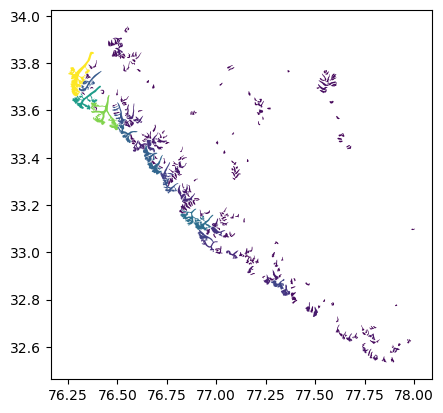

In [95]:
gdf.plot('area')

In [96]:
gdf1 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/SHAYOK_GLACIERS_1977.gpkg')

In [97]:
gdf1.head()

JNUOAId           RGIId         GLIMSId     CenLon     CenLat  Zmax  Zmean  \
0     SH1  RGI60-14.05890  G077428E35296N  77.428851  35.440308  6717   5673   
1     SH2  RGI60-14.05890  G077428E35296N  77.468098  35.327357  7187   5630   
2     SH3  RGI60-14.07524  G076894E35428N  77.127898  35.283093  5975   5450   
3     SH4  RGI60-14.05890  G077428E35296N  77.345690  35.303037  6846   5483   
4     SH5  RGI60-14.07779  G077294E35212N  77.301161  35.214637  5991   5410   

   Zmin  MeanAspect  MeanSlope        Area       Lmax    U_Area    U_Lmax  \
0  4892          95        8.0  216.433901  42.939683  4.557398  1.116432   
1  4933          68       12.0  156.991270  23.648864  4.260366  0.614870   
2  5143         169       19.0    1.013981   2.551032  0.107123  0.066327   
3  3967         216       16.0   89.617428  21.099112  3.969673  0.548577   
4  4390          32       18.0    5.035147   6.632980  0.331163  0.172457   

                                            geometry  
0  MULTIPOLYGON (((724214.933 3918367.741, 724220...  
1  MULTIPOLYGON (((723038.038 3905916.036, 723014...  
2  MULTIPOLYGON (((693514.497 3907705.002, 693514...  
3  MULTIPOLYGON (((714532.859 3907485.004, 714494...  
4  MULTIPOLYGON (((710504.931 3898335.004, 710504...

In [98]:
gdf1.shape

(1262, 15)

In [99]:
gdf1.shape

(1262, 15)

In [100]:
gdf1['area'] = gdf1.area

In [101]:
gdf1 = gdf1.to_crs(epsg=4326)
gdf1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

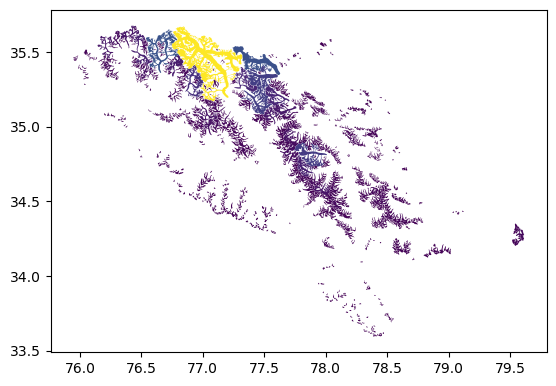

In [102]:
gdf1.plot('area')


In [103]:
gdf2 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/LEH_GLACIERS_1977.gpkg')

In [104]:
gdf2['area'] = gdf2.area

In [105]:
gdf2 = gdf2.to_crs(epsg=4326)
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

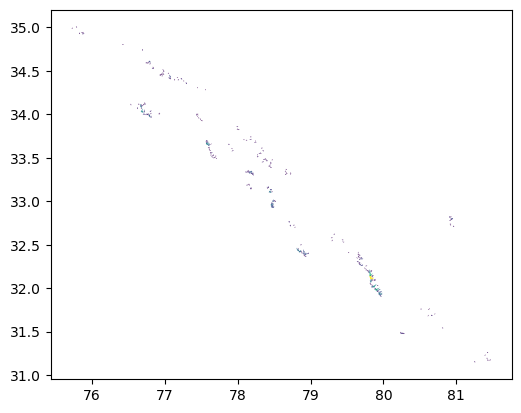

In [106]:
gdf2.plot('area')

In [107]:
gdf3 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/SURU_GLACIERS_1977.gpkg')

In [108]:
gdf3['area'] = gdf3.area

In [109]:
gdf3 = gdf3.to_crs(epsg=4326)
gdf3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

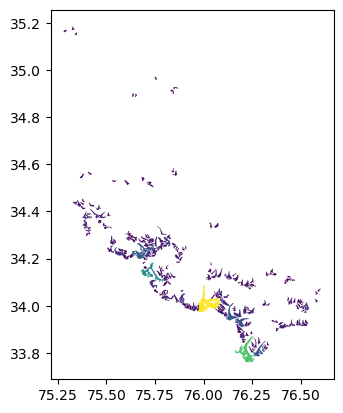

In [110]:
gdf3.plot('area')

In [111]:
gdf4 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/TSOKAR_GLACIERS_1977.gpkg')

In [112]:
gdf4['area'] = gdf4.area

In [113]:
gdf4 = gdf4.to_crs(epsg=4326)
gdf4.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

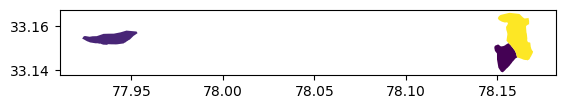

In [114]:
gdf4.plot('area')

In [115]:
gdf5 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/TSOMORIRI_GLACIERS_1977.gpkg')

In [116]:
gdf5['area'] = gdf5.area

In [117]:
gdf5 = gdf5.to_crs(epsg=4326)
gdf5.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

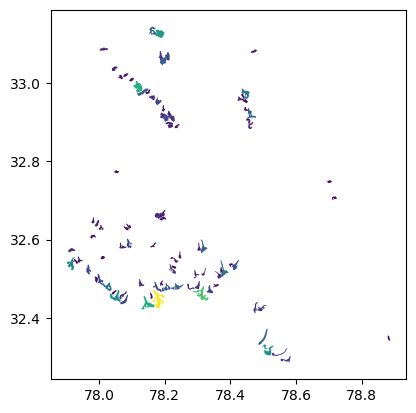

In [118]:
gdf5.plot('area')

In [119]:
gdf6 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/DATA IN GEOPACKAGE FORMAT/GLACIER_OUTLINES/ZANSKAR_GLACIERS_1977.gpkg')

In [120]:
gdf6['area'] = gdf6.area

In [121]:
gdf6 = gdf6.to_crs(epsg=4326)
gdf6.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

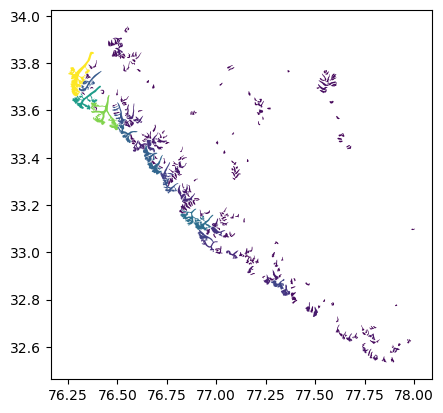

In [122]:
gdf6.plot('area')

In [125]:
gdf = pd.concat([gdf, gdf1, gdf2, gdf3, gdf4, gdf5, gdf6])

In [126]:
# Visualize
location = [34.0, 77.5]  # For ladakh regions just a point somehwere in the rectangle
m = folium.Map(location=location, zoom_start=7)

# Define the bounds of the rectangle. Format: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[75, 36], [82, 32]]

# Add the rectangle to the map
folium.Rectangle(
    bounds=bounds,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)

for _, r in gdf.iterrows():
    # Without simplifying the representation of part,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Popup(r["JNUOAId"]).add_to(geo_j)
    geo_j.add_to(m)
    


# Add the raw image to the map
vis_params = {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}
m.add_ee_layer(landsat, vis_params, 'Landsat Image')

# Add the glacier mask to the map
#m.add_ee_layer(glacier_mask.updateMask(glacier_mask), {'palette': 'blue'}, 'Glacier Mask')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)